# Image segmentation and neural network quantization

Here are all the import statements needed for all the exercises

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_model_optimization as tfmot
import tensorflow.lite

Loading the Sentinel 2 dataset. Images and labels are padded to be 256x256 in size and normalized by their maximum value. 40 images are used for the train partition (X_train, Y_train) and 10 for testing (X_test, Y_test)

In [2]:
loaded = np.load('sentinel2.npz')
X = loaded['X'].astype(np.float32)
Y = loaded['Y'].astype(np.float32)
X = np.pad(X, ((0, 0), (3, 3), (3, 3), (0, 0)))
Y = np.pad(Y, ((0, 0), (3, 3), (3, 3), (0, 0)))
X_train = X[:40] / np.max(X[:40])
X_test = X[40:] / np.max(X[:40])
Y_train = Y[:40]
Y_test = Y[40:]

**[TODO]** Implement the U-net neural network for segmentation as drawn in the lab document.

In [4]:
def conv_layer(features, stride, kernel_size=3, k_regularizer=tf.keras.regularizers.l2(0.01)):
    return tf.keras.layers.Conv2D(features,
                                  kernel_size=kernel_size,
                                  strides=(stride, stride),
                                  padding='same',
                                  # kernel_initializer='glorot_normal',
                                  # kernel_regularizer=k_regularizer
                                  )


def post_layer(inputs):
    h = tf.keras.layers.BatchNormalization()(inputs)
    return tf.keras.layers.Activation('relu')(h)
    # return tf.keras.layers.LeakyReLU(alpha=0.1)(h)

In [5]:
def build_unet_base(inputs, init_features=32):
    N = 2
    # Building h10
    h1 = conv_layer(init_features, 1)(inputs)
    h1 = post_layer(h1)
    h1 = conv_layer(init_features, 1)(h1)
    h10 = post_layer(h1)
    # Building h20
    h2 = conv_layer(2 * init_features, 2)(h10)
    h20 = post_layer(h2)
    # Building h30
    h3 = conv_layer(4 * init_features, 2)(h20)
    h3 = post_layer(h3)
    h3 = conv_layer(4 * init_features, 1)(h3)
    h3 = post_layer(h3)
    h30 = tf.keras.layers.UpSampling2D()(h3)
    # Building h21
    h2 = tf.keras.layers.Concatenate()([h20, h30])
    h2 = conv_layer(2 * init_features, 1)(h2)
    h2 = post_layer(h2)
    h21 = tf.keras.layers.UpSampling2D()(h2)
    # Building h11
    h1 = tf.keras.layers.Concatenate()([h10, h21])
    h1 = conv_layer(init_features, 1)(h1)
    h11 = post_layer(h1)
    # Classification
    return tf.keras.layers.Conv2D(N,
                                  kernel_size=1,
                                  padding='same',
                                  activation='softmax'
                                  )(h11)


def build_unet_custom(inputs, dropout=False, dropout_percent=0.2, init_features=32):
    N = 2
    # Building h10
    h1 = conv_layer(init_features, 1)(inputs)
    h1 = post_layer(h1)
    if dropout:
        h1 = tf.keras.layers.Dropout(dropout_percent)(h1)
    h1 = conv_layer(init_features, 1)(h1)
    h10 = post_layer(h1)
    if dropout:
        h10 = tf.keras.layers.Dropout(dropout_percent)(h10)
    # Building h20
    h2 = conv_layer(2 * init_features, 2)(h10)
    # h2 = tf.keras.layers.AvgPool2D(padding='same')(h2)
    h20 = post_layer(h2)
    if dropout:
        h20 = tf.keras.layers.Dropout(dropout_percent)(h20)
    # Building h30
    h3 = conv_layer(4 * init_features, 2)(h20)
    # h3 = tf.keras.layers.MaxPool2D(padding='same')(h3)
    h3 = post_layer(h3)
    if dropout:
        h3 = tf.keras.layers.Dropout(dropout_percent)(h3)
    h3 = conv_layer(4 * init_features, 1)(h3)
    h3 = post_layer(h3)
    h30 = tf.keras.layers.UpSampling2D()(h3)
    if dropout:
        h30 = tf.keras.layers.Dropout(dropout_percent)(h30)
    # Building h21
    h2 = tf.keras.layers.Concatenate()([h20, h30])
    h2 = conv_layer(2 * init_features, 1)(h2)
    h2 = post_layer(h2)
    if dropout:
        h2 = tf.keras.layers.Dropout(dropout_percent)(h2)
    h21 = tf.keras.layers.UpSampling2D()(h2)
    # Building h11
    h1 = tf.keras.layers.Concatenate()([h10, h21])
    h1 = conv_layer(init_features, 1)(h1)
    h11 = post_layer(h1)
    if dropout:
        h11 = tf.keras.layers.Dropout(dropout_percent)(h11)
    # Classification
    return tf.keras.layers.Conv2D(N,
                                  kernel_size=1,
                                  padding='same',
                                  activation='sigmoid',
                                  kernel_regularizer=None
                                  )(h11)

In [19]:
# Clearing previous model
tf.keras.backend.clear_session()
# epoch_counter = 0
# Inputs
inputs = tf.keras.layers.Input(shape=(256, 256, 12))
# outputs = build_unet_custom(inputs, dropout=False, init_features=8)
outputs = build_unet_base(inputs, init_features=128)
print(f'Shape of the output: {outputs.shape[1:]}')

Shape of the output: (256, 256, 2)


**[TODO]** Compile and train the model (might take some time...)

In [20]:
# Compiling
if tf.io.gfile.exists('./models/cultivated_recognition_try'):
    model = tf.keras.models.load_model('./models/cultivated_recognition_try')
    print('Model loaded!')
else:
    model = tf.keras.Model(inputs, outputs)
model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [21]:
# Training
batch_size = 2
dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
dataset = dataset.batch(batch_size)
dataset_test = tf.data.Dataset.from_tensor_slices((X_test, Y_test))
dataset_test = dataset_test.batch(batch_size)
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    verbose=1,
    restore_best_weights=True
)
# model.fit(X_train, Y_train, batch_size=batch_size, epochs=100, validation_data=(X_test, Y_test), callbacks=[callback])
# model.fit(dataset, epochs=100, validation_data=dataset_test)

In [24]:
model.fit(X_train, Y_train, batch_size=batch_size, epochs=100, validation_data=(X_test, Y_test), callbacks=[callback])

Epoch 1/100
20/20 [==============================] - 6s 274ms/step - loss: 0.2296 - accuracy: 0.9062 - val_loss: 0.7433 - val_accuracy: 0.5844
Epoch 2/100
20/20 [==============================] - 5s 268ms/step - loss: 0.2203 - accuracy: 0.9102 - val_loss: 0.2265 - val_accuracy: 0.9232
Epoch 3/100
20/20 [==============================] - 5s 267ms/step - loss: 0.2518 - accuracy: 0.9046 - val_loss: 0.2634 - val_accuracy: 0.8884
Epoch 4/100
20/20 [==============================] - 5s 266ms/step - loss: 0.2546 - accuracy: 0.8956 - val_loss: 0.3145 - val_accuracy: 0.8407
Epoch 5/100
20/20 [==============================] - 5s 267ms/step - loss: 0.2347 - accuracy: 0.9044 - val_loss: 0.4112 - val_accuracy: 0.8496
Epoch 6/100
20/20 [==============================] - 5s 266ms/step - loss: 0.2361 - accuracy: 0.9052 - val_loss: 0.2832 - val_accuracy: 0.9026
Epoch 7/100
20/20 [==============================] - 5s 266ms/step - loss: 0.2214 - accuracy: 0.9101 - val_loss: 0.2490 - val_accuracy: 0.8968

In [43]:
# while True:
#     epoch_counter += 1
#     print(f'Epoch {epoch_counter}')
#     res = model.fit(X_train, Y_train, batch_size=batch_size, epochs=1, validation_data=(X_test, Y_test))
#     if res.history['val_accuracy'][0] >= 0.92:
#         break

Epoch 41


ResourceExhaustedError: Graph execution error:

Detected at node 'gradient_tape/model/conv2d_6/Conv2D/Conv2DBackpropInput' defined at (most recent call last):
    File "C:\Users\steur\miniconda3\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\steur\miniconda3\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\steur\miniconda3\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\steur\miniconda3\lib\site-packages\traitlets\config\application.py", line 992, in launch_instance
      app.start()
    File "C:\Users\steur\miniconda3\lib\site-packages\ipykernel\kernelapp.py", line 736, in start
      self.io_loop.start()
    File "C:\Users\steur\miniconda3\lib\site-packages\tornado\platform\asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\steur\miniconda3\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "C:\Users\steur\miniconda3\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "C:\Users\steur\miniconda3\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\steur\miniconda3\lib\site-packages\ipykernel\kernelbase.py", line 516, in dispatch_queue
      await self.process_one()
    File "C:\Users\steur\miniconda3\lib\site-packages\ipykernel\kernelbase.py", line 505, in process_one
      await dispatch(*args)
    File "C:\Users\steur\miniconda3\lib\site-packages\ipykernel\kernelbase.py", line 412, in dispatch_shell
      await result
    File "C:\Users\steur\miniconda3\lib\site-packages\ipykernel\kernelbase.py", line 740, in execute_request
      reply_content = await reply_content
    File "C:\Users\steur\miniconda3\lib\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "C:\Users\steur\miniconda3\lib\site-packages\ipykernel\zmqshell.py", line 546, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\steur\miniconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3024, in run_cell
      result = self._run_cell(
    File "C:\Users\steur\miniconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3079, in _run_cell
      result = runner(coro)
    File "C:\Users\steur\miniconda3\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\steur\miniconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3284, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\steur\miniconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3466, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\steur\miniconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3526, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "D:\Temp\ipykernel_17268\2293028591.py", line 4, in <module>
      res = model.fit(X_train, Y_train, batch_size=batch_size, epochs=1, validation_data=(X_test, Y_test))
    File "C:\Users\steur\miniconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\steur\miniconda3\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\steur\miniconda3\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "C:\Users\steur\miniconda3\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\steur\miniconda3\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "C:\Users\steur\miniconda3\lib\site-packages\keras\engine\training.py", line 997, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "C:\Users\steur\miniconda3\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 576, in minimize
      grads_and_vars = self._compute_gradients(
    File "C:\Users\steur\miniconda3\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 634, in _compute_gradients
      grads_and_vars = self._get_gradients(
    File "C:\Users\steur\miniconda3\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 510, in _get_gradients
      grads = tape.gradient(loss, var_list, grad_loss)
Node: 'gradient_tape/model/conv2d_6/Conv2D/Conv2DBackpropInput'
OOM when allocating tensor with shape[2,384,256,256] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node gradient_tape/model/conv2d_6/Conv2D/Conv2DBackpropInput}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_40724]

**[TODO]** Test the model on the test set and measure the accuracy.

In [25]:
# model.evaluate(X_test, Y_test)
model.evaluate(dataset_test)

5/5 [==============================] - 1s 92ms/step - loss: 0.2265 - accuracy: 0.9232


[0.2265067845582962, 0.9231842160224915]

In [26]:
# test_pred = np.argmax(model.predict(X_test), axis=-1)
test_pred = np.argmax(model.predict(dataset_test), axis=-1)
print(np.unique(test_pred, return_counts=True))

5/5 [==============================] - 0s 85ms/step
(array([0, 1], dtype=int64), array([486847, 168513], dtype=int64))


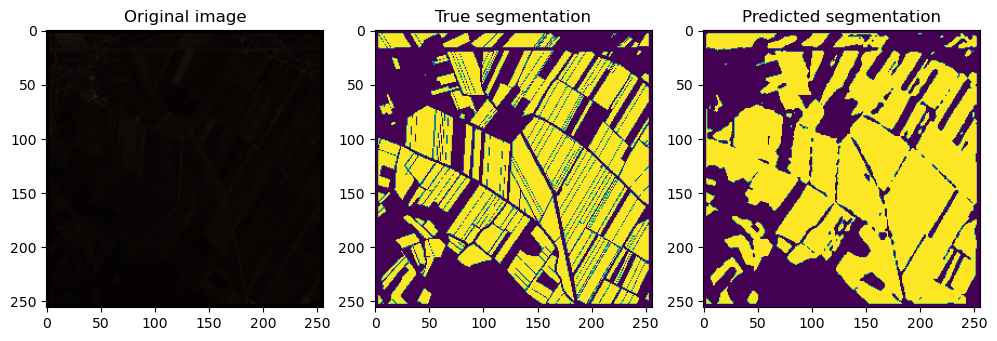

In [40]:
# Comparing the results
img_index = 3
plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1)
plt.title('Original image')
plt.imshow(X_test[img_index, :, :, 2::-1])
plt.subplot(1, 3, 2)
plt.title('True segmentation')
plt.imshow(Y_test[img_index, :, :])
plt.subplot(1, 3, 3)
plt.title('Predicted segmentation')
plt.imshow(test_pred[img_index, :, :])
plt.tight_layout()
plt.show()

In [41]:
# Saving the model
model.save('./models/cultivated_recognition')

INFO:tensorflow:Assets written to: ./models/cultivated_recognition\assets


INFO:tensorflow:Assets written to: ./models/cultivated_recognition\assets


**[TODO]** Convert model to TFLite with 8-bit weight quantization 

In [42]:
converter = tf.lite.TFLiteConverter.from_saved_model('./models/cultivated_recognition')
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converted_model = converter.convert()
with open('./tfl_cultivated_recognition.tflite', 'wb') as f:
    f.write(converted_model)

**[TODO]** Test the accuracy of the quantized model by writing your own "evaluate" function. Remember that TFLite interpreter can only process one sample at a time, not a batch.

In [209]:
def tflite_evaluate(interpreter, images_data, images_labels):
    N = images_data.shape[0]
    Npx = images_data.shape[1] * images_data.shape[2]
    input_index = interpreter.get_input_details()[0]['index']
    output_index = interpreter.get_output_details()[0]['index']
    mse = []
    accuracy = 0
    for i in range(N):
        # Obtaining single data from input dataset
        test_data = images_data[i:(i + 1)]
        test_label = images_labels[i:(i + 1)]
        # Feeding data into the input tensor
        interpreter.set_tensor(input_index, test_data)
        # Running the model
        interpreter.invoke()
        out_tensor = interpreter.get_tensor(output_index)
        prediction_oh = out_tensor[:, :, :, 1:2]
        prediction = np.argmax(out_tensor, axis=-1)
        # Computing MSE of i-th image and hit or miss
        err = np.power(test_label - prediction_oh, 2)
        pred_err = test_label[:, :, :, 0] - prediction
        acc = np.count_nonzero(pred_err == 0) / Npx
        print(f'Prediction #{i + 1}: Loss = {np.sum(err)}; Accuracy = {acc}')
        # Computing overall score
        mse.append(err)
        accuracy += acc
    return [np.mean(mse), accuracy / N]

In [ ]:
# Evaluating the TFLite model
interpreter = tf.lite.Interpreter(model_content=converted_model)
interpreter.allocate_tensors()
e_MSE, accuracy = tflite_evaluate(interpreter, X_test, Y_test)
print(f'Overall MSE = {e_MSE}; Overall accuracy = {accuracy}')

Prediction #1: Loss = 2276.216064453125; Accuracy = 0.9552154541015625


**[TODO]** Finetune the Keras model using quantization-aware training and measure the accuracy on the test set after actually quantizing it 

In [34]:
# Importing the model into a new quantization-aware model
quant_aware_model = tfmot.quantization.keras.quantize_model(model)
quant_aware_model.compile(optimizer=tf.keras.optimizers.Adam(0.01), loss='sparse_categorical_crossentropy',
                          metrics=['accuracy'])

In [35]:
quant_aware_model.fit(X_train, Y_train, batch_size=8, epochs=50)

Epoch 1/50
5/5 [==============================] - 8s 381ms/step - loss: 0.3391 - accuracy: 0.8654
Epoch 2/50
5/5 [==============================] - 2s 378ms/step - loss: 0.3074 - accuracy: 0.8573
Epoch 3/50
5/5 [==============================] - 2s 378ms/step - loss: 0.2929 - accuracy: 0.8773
Epoch 4/50
5/5 [==============================] - 2s 375ms/step - loss: 0.2852 - accuracy: 0.8861
Epoch 5/50
5/5 [==============================] - 2s 374ms/step - loss: 0.2913 - accuracy: 0.8807
Epoch 6/50
5/5 [==============================] - 2s 379ms/step - loss: 0.2634 - accuracy: 0.8903
Epoch 7/50
5/5 [==============================] - 2s 387ms/step - loss: 0.2654 - accuracy: 0.8894
Epoch 8/50
5/5 [==============================] - 2s 377ms/step - loss: 0.2597 - accuracy: 0.8918
Epoch 9/50
5/5 [==============================] - 2s 379ms/step - loss: 0.2638 - accuracy: 0.8874
Epoch 10/50
5/5 [==============================] - 2s 376ms/step - loss: 0.2536 - accuracy: 0.8913
Epoch 11/50
5/5 [==

In [36]:
# Converting the new model into a TFLite model
converter = tf.lite.TFLiteConverter.from_keras_model(quant_aware_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
quantized_aware_model = converter.convert()

INFO:tensorflow:Assets written to: D:\Temp\tmpt0savk3p\assets


INFO:tensorflow:Assets written to: D:\Temp\tmpt0savk3p\assets
C:\Users\steur\miniconda3\lib\site-packages\tensorflow\lite\python\convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


In [39]:
# Evaluating the TFLite model
interpreter = tf.lite.Interpreter(model_content=converted_model)
interpreter.allocate_tensors()
e_MSE = tflite_evaluate(interpreter, X_test, Y_test)
print(e_MSE)

Prediction #1: Loss = 3635.87109375; Accuracy = 0.9259033203125
Prediction #2: Loss = 3920.905517578125; Accuracy = 0.909210205078125
Prediction #3: Loss = 1882.6981201171875; Accuracy = 0.964111328125
Prediction #4: Loss = 9627.689453125; Accuracy = 0.7836151123046875
Prediction #5: Loss = 9678.111328125; Accuracy = 0.783203125
Prediction #6: Loss = 7670.935546875; Accuracy = 0.8314056396484375
Prediction #7: Loss = 1956.30029296875; Accuracy = 0.9674072265625
Prediction #8: Loss = 4518.55712890625; Accuracy = 0.90631103515625
Prediction #9: Loss = 3106.78271484375; Accuracy = 0.941009521484375
Prediction #10: Loss = 9647.8505859375; Accuracy = 0.79473876953125
[0.084908605, 0.8806915283203125]
